<a href="https://colab.research.google.com/github/CarlHad333/Non_Verbal_Behaviour/blob/main/SER_IEMOCAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modality : Speech
- **Features**: MFCC coefficients
- **Classifier** : Logistic regression
- **Emotions** : neu, and, hap, sad


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#importing necessary packages
import numpy as np
import pandas as pd
import os
import pandas
import librosa
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel

In [3]:
def get_labels(annot_file, file_name):

    f = open(annot_file, 'r').read()
    f = f.split('\n')
    f = f[2:]

    for data in f:

        if len(data) > 0:
            if data[0] == '[':
                data2 = data.split('\t')

                if data2[1] == file_name:
                    emo = data2[2]
                    vad = data2[3][1:-1].split(', ')
                    return emo, [float(x) for x in vad]

    raise ValueError('Label not found')
def get_wav(path):
    '''returns the signal as a tensor + the sample rate'''
    x, sr = librosa.load(path, sr=16000)
    return x, sr

In [4]:
root_path = '/content/gdrive/MyDrive/IEMOCAP_full_release_withoutVideos_sentenceOnly'

df = pandas.read_csv(os.path.join(root_path, 'iemocap.csv'))

display(df.head())

,Unnamed: 0,session,method,gender,n_annotators,agreement,emotion,valence,activation,dominance,wav_path,MOCAP_rotated_path,MOCAP_head_path,MOCAP_hand_path,FA_ph_path,FA_st_path,FA_sy_path,FA_wd_path
0,0,1,script,F,3,3,neu,2.5,2.0,2.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
1,1,1,script,F,3,2,fru,2.5,2.0,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
2,2,1,script,F,0,0,xxx,2.0,2.0,2.5,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
3,3,1,script,F,3,2,sur,2.5,3.0,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...
4,4,1,script,F,3,2,neu,2.0,3.0,3.0,IEMOCAP_full_release/Session1/sentences/wav/Se...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/MOCAP_...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...,IEMOCAP_full_release/Session1/sentences/Forced...


In [5]:
#Let's check how many examples per class we do have
df.emotion.value_counts()

xxx    2507
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
sur     107
fea      40
oth       3
dis       2
Name: emotion, dtype: int64

*Let's represent the data above as a histogram*

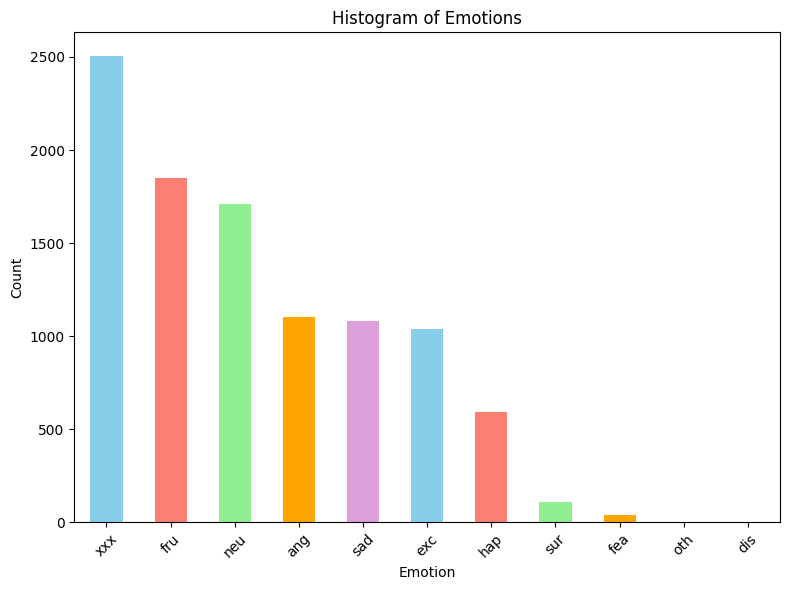

In [6]:
import matplotlib.pyplot as plt
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'plum']  # Add more colors if needed

plt.figure(figsize=(8, 6))
df.emotion.value_counts().plot(kind='bar', color=colors)
plt.title('Histogram of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)  # for better readability of labels
plt.tight_layout()
plt.show()

Based on the histogram above, we'll get of all the under-represented classes, we'll only keep the following emotions: 'hap', 'sad', 'ang', 'neu'. Note that 'exc' will be merged with happy into one class.

In [7]:
df_filtered = df[df['agreement'] >= 2]  # We'll only use recordings where 3/4 or 4/4 annotators agree on emotion
desired_emotions = ['sad', 'ang', 'hap', 'neu']

# Merge 'exc' with 'hap'
df_filtered.loc[df_filtered['emotion'] == 'exc', 'emotion'] = 'hap'

df_filtered = df_filtered[df_filtered['emotion'].isin(desired_emotions)]
df_filtered.emotion.value_counts()

neu    1708
hap    1636
ang    1103
sad    1084
Name: emotion, dtype: int64

In [8]:
# Now let's balance the dataset
balanced_df = df_filtered.groupby('emotion', group_keys=False).apply(lambda x: x.sample(min(len(x), 1084)))
balanced_df['emotion'].value_counts()

ang    1084
hap    1084
neu    1084
sad    1084
Name: emotion, dtype: int64

We'll use MFCC coefficients as a feature for audio data. Below we define the function that extracts mfcc_coeffs from audio data.

In [ ]:
def extract_mfcc(audio_data, sample_rate):
    # Extract MFCC (Mel-frequency cepstral coefficients) features
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)

    # Calculate the mean of MFCC coefficients across time
    mfccs_mean = np.mean(mfccs, axis=1)

    # Calculate the standard deviation of MFCC coefficients across time
    mfccs_std = np.std(mfccs, axis=1)

    # Concatenate mean and standard deviation to create feature vector
    audio_features = np.concatenate((mfccs_mean, mfccs_std)) #shape (26,)

    return audio_features

In [ ]:
#Session 1,2,3,4 for train, 5 for test
train_data = balanced_df[balanced_df['session'].isin([1, 2, 3, 4])]
test_data = balanced_df[balanced_df['session'] == 5]
train_data.emotion.value_counts()

ang    916
neu    851
sad    839
hap    770
Name: emotion, dtype: int64

In [ ]:
train_features = []
train_labels = []
test_features = []
test_labels = []

for index, row in train_data.iterrows():

    # Audio data
    x, sr = get_wav(os.path.join(root_path, row['wav_path']))
    # Extract mfcc from audio data
    audio_features = extract_mfcc(x, sr)
    # Get emotion label
    _, file_name = os.path.split(row['wav_path'])
    annot_file = os.path.join(root_path, 'IEMOCAP_full_release',
                              'Session'+str(row['session']),
                              'dialog', 'EmoEvaluation',
                              file_name[:-9] + '.txt')
    emo, _ = get_labels(annot_file, file_name[:-4])

    # Append features and labels
    if emo == 'exc':  #for some reason 'exc' wasn't completly filtered, so we're handling the left values like this
      train_features.append(audio_features)
      train_labels.append('hap')
    else:
      train_features.append(audio_features)
      train_labels.append(emo)

#test data
for index, row in test_data.iterrows():
    # Audio data
    x, sr = get_wav(os.path.join(root_path, row['wav_path']))
    # Extract mfcc from audio data
    audio_features = extract_mfcc(x, sr)

    # Get emotion label
    _, file_name = os.path.split(row['wav_path'])
    annot_file = os.path.join(root_path, 'IEMOCAP_full_release',
                              'Session'+str(row['session']),
                              'dialog', 'EmoEvaluation',
                              file_name[:-9] + '.txt')
    emo, _ = get_labels(annot_file, file_name[:-4])
    # Append features and labels
    if emo == 'exc':
       test_features.append(audio_features)
       test_labels.append('hap')
    else:
      test_features.append(audio_features)
      test_labels.append(emo)

# Convert lists to numpy arrays
X_train = np.array(train_features)
y_train = np.array(train_labels)
X_test = np.array(test_features)
y_test = np.array(test_labels)

#Model:
- Feature: MFCC
- Classifier : Logistic regression

In [ ]:
# Train the model
model_speech = LogisticRegression(max_iter = 12000)
model_speech.fit(X_train, y_train)

# Test the model
predictions = model_speech.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.503125


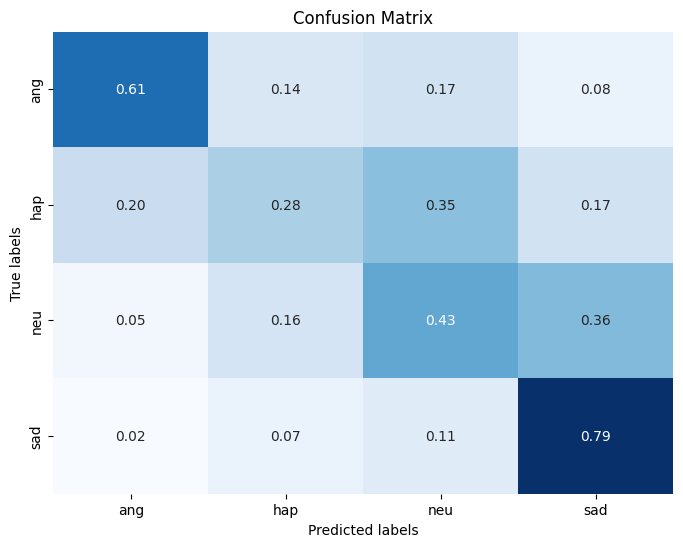

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

text_labels = ['ang', 'hap', 'neu', 'sad']

# Predict labels for the test set
predicted_labels = model_speech.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=text_labels, yticklabels=text_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
